# 10.6 사전 훈련된 워드 임베딩(Pre-trained Word Embedding)
자연어 처리를 하려고 할 때 갖고 있는 훈련 데이터의 단어들을 임베딩 층(embedding layer)을 구현하여 임베딩 벡터로 학습하는 경우가 있습니다. 케라스에서는 이를 Embedding()이라는 도구를 사용하여 구현합니다.

그런데 
- 위키피디아 등과 같은 방대한 코퍼스를 가지고 Word2vec, FastText, GloVe 등을 통해서 이미 미리 훈련된 임베딩 벡터를 불러오는 방법을 사용하는 경우도 있습니다. 
- 이는 현재 갖고 있는 훈련 데이터를 임베딩 층으로 처음부터 학습을 하는 방법과는 대조됩니다.

### 1. 케라스 임베딩 층(Keras Embedding layer)
케라스는 훈련 데이터의 단어들에 대해 워드 임베딩을 수행하는 도구 Embedding()을 제공합니다. Embedding()은 인공 신경망 구조 관점에서 임베딩 층(embedding layer)을 구현합니다.

##### 1) 임베딩 층은 룩업 테이블이다.
임베딩 층의 입력으로 사용하기 위해서 입력 시퀀스의 각 단어들은 모두 정수 인코딩이 되어있어야 합니다.

어떤 단어 → 단어에 부여된 고유한 정수값 → 임베딩 층 통과 → 밀집 벡터

임베딩 층은 입력 정수에 대해 밀집 벡터(dense vector)로 맵핑하고 이 밀집 벡터는 인공 신경망의 학습 과정에서 가중치가 학습되는 것과 같은 방식으로 훈련됩니다. 훈련 과정에서 단어는 모델이 풀고자하는 작업에 맞는 값으로 업데이트 됩니다. 그리고 이 밀집 벡터를 임베딩 벡터라고 부릅니다.

정수를 밀집 벡터 또는 임베딩 벡터로 맵핑한다는 것은 어떤 의미일까요? 특정 단어와 맵핑되는 정수를 인덱스로 가지는 테이블로부터 임베딩 벡터 값을 가져오는 룩업 테이블이라고 볼 수 있습니다. 그리고 이 테이블은 단어 집합의 크기만큼의 행을 가지므로 모든 단어는 고유한 임베딩 벡터를 가집니다.

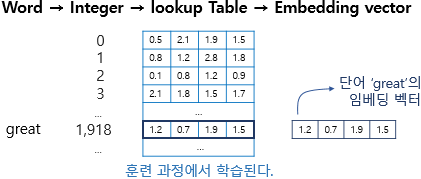

위의 그림은 단어 great이 정수 인코딩 된 후 테이블로부터 해당 인덱스에 위치한 임베딩 벡터를 꺼내오는 모습을 보여줍니다. 위의 그림에서는 임베딩 벡터의 차원이 4로 설정되어져 있습니다. 그리고 단어 great은 정수 인코딩 과정에서 1,918의 정수로 인코딩이 되었고 그에 따라 단어 집합의 크기만큼의 행을 가지는 테이블에서 인덱스 1,918번에 위치한 행을 단어 great의 임베딩 벡터로 사용합니다. 이 임베딩 벡터는 모델의 입력이 되고, 역전파 과정에서 단어 great의 임베딩 벡터값이 학습됩니다.

룩업 테이블의 개념을 이론적으로 우선 접하고, 처음 케라스를 배울 때 어떤 분들은 임베딩 층의 입력이 원-핫 벡터가 아니어도 동작한다는 점에 헷갈려 합니다. 케라스는 단어를 정수 인덱스로 바꾸고 원-핫 벡터로 한번 더 바꾸고나서 임베딩 층의 입력으로 사용하는 것이 아니라, 단어를 정수 인덱스로만 바꾼채로 임베딩 층의 입력으로 사용해도 룩업 테이블 된 결과인 임베딩 벡터를 리턴합니다.

케라스의 임베딩 층 구현 코드를 봅시다.

```python
# 아래의 각 인자는 저자가 임의로 선정한 숫자들이며 의미있는 선정 기준이 아님.
v = Embedding(20000, 128, input_length=500)
# vocab_size = 20000
# output_dim = 128
# input_length = 500
임베딩 층은 다음과 같은 세 개의 인자를 받습니다.
```
- vocab_size : 텍스트 데이터의 전체 단어 집합의 크기입니다.
- output_dim : 워드 임베딩 후의 임베딩 벡터의 차원입니다.
- input_length : 입력 시퀀스의 길이입니다. 만약 갖고있는 각 샘플의 길이가 500개의 단어로 구성되어있다면 이 값은 500이 됩니다.

Embedding()은 (number of samples, input_length)인 2D 정수 텐서를 입력받습니다. 이 때 각 sample은 정수 인코딩이 된 결과로, 정수의 시퀀스입니다. Embedding()은 워드 임베딩 작업을 수행하고 (number of samples, input_length, embedding word dimentionality)인 3D 실수 텐서를 리턴합니다. 케라스의 임베딩 층(embedding layer)을 사용하는 간단한 실습을 진행해보겠습니다.

##### 2) 임베딩 층 사용하기
RNN 챕터에서 이미 사용한 바 있지만, 임베딩 층을 복습해보겠습니다. 문장의 긍, 부정을 판단하는 감성 분류 모델을 만들어봅시다.

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [3]:
sentences = ['nice great best amazing', 'stop lies', 'pitiful nerd', 'excellent work', 'supreme quality', 'bad', 'highly respectable']

train_y = [1,0,0,1,1,0,1]

문장과 레이블 데이터를 만들었습니다. 긍정인 문장은 레이블 1, 부정인 문장은 레이블이 0입니다.

In [4]:
tkn = Tokenizer()
tkn.fit_on_texts(sentences)
vc_size = len(tkn.word_index)+1

print(vc_size)

16


케라스의 Tokenizer()를 사용하여 토큰화를 시켰습니다

In [8]:
encoded_x = tkn.texts_to_sequences(sentences)
print(encoded_x)

[[1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 15]]


In [9]:
max_len = max(len(l) for l in encoded_x)
print(max_len)

4


In [11]:
train_x = pad_sequences(encoded_x, maxlen = max_len, padding='post')
train_y = np.array(train_y)
print(train_x)

[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14 15  0  0]]


In [13]:
# Model design
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

In [15]:
model = Sequential()
model.add(Embedding(vc_size, 4, input_length=max_len)) # 모든 임베딩 백터는 4차원
model.add(Flatten()) # Endse의 입력으로 넣기 위함
model.add(Dense(1, activation='sigmoid'))

출력층에 1개의 뉴런에 활성화 함수로는 시그모이드 함수를 사용하여 이진 분류를 수행합니다.

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(train_x, train_y, epochs=100, verbose=2)

Epoch 1/100
7/7 - 1s - loss: 0.6928 - acc: 0.4286
Epoch 2/100
7/7 - 0s - loss: 0.6911 - acc: 0.4286
Epoch 3/100
7/7 - 0s - loss: 0.6893 - acc: 0.4286
Epoch 4/100
7/7 - 0s - loss: 0.6876 - acc: 0.5714
Epoch 5/100
7/7 - 0s - loss: 0.6859 - acc: 0.7143
Epoch 6/100
7/7 - 0s - loss: 0.6841 - acc: 0.8571
Epoch 7/100
7/7 - 0s - loss: 0.6824 - acc: 0.8571
Epoch 8/100
7/7 - 0s - loss: 0.6807 - acc: 0.8571
Epoch 9/100
7/7 - 0s - loss: 0.6790 - acc: 0.8571
Epoch 10/100
7/7 - 0s - loss: 0.6773 - acc: 0.8571
Epoch 11/100
7/7 - 0s - loss: 0.6755 - acc: 0.8571
Epoch 12/100
7/7 - 0s - loss: 0.6738 - acc: 1.0000
Epoch 13/100
7/7 - 0s - loss: 0.6721 - acc: 1.0000
Epoch 14/100
7/7 - 0s - loss: 0.6704 - acc: 1.0000
Epoch 15/100
7/7 - 0s - loss: 0.6687 - acc: 1.0000
Epoch 16/100
7/7 - 0s - loss: 0.6670 - acc: 1.0000
Epoch 17/100
7/7 - 0s - loss: 0.6653 - acc: 1.0000
Epoch 18/100
7/7 - 0s - loss: 0.6635 - acc: 1.0000
Epoch 19/100
7/7 - 0s - loss: 0.6618 - acc: 1.0000
Epoch 20/100
7/7 - 0s - loss: 0.6601 - a

테스트 데이터에 대한 정확도가 아니며 훈련 데이터도 양이 적어서 정확도에 의미는 없지만, 여기서 말하고자 하는 점은 현재 각 단어들의 임베딩 벡터들의 값은 학습 과정에서 다른 가중치들과 함께 학습된 값입니다.

### 2. 사전 훈련된 워드 임베딩(Pre-Trained Word Embedding) 사용하기
임베딩 벡터를 얻기 위해서 케라스의 Embedding()을 사용하기도 하지만, 때로는 이미 훈련되어져 있는 워드 임베딩을 불러서 이를 임베딩 벡터로 사용하기도 합니다. 훈련 데이터가 적은 상황이라면 모델에 케라스의 Embedding()을 사용하는 것보다 다른 텍스트 데이터로 사전 훈련되어 있는 임베딩 벡터를 불러오는 것이 나은 선택일 수 있습니다.

훈련 데이터가 적다면 케라스의 Embedding()으로 해당 문제에 충분히 특화된 임베딩 벡터를 만들어내는 것이 쉽지 않습니다. 차라리 해당 문제에 특화된 임베딩 벡터를 만드는 것이 어렵다면, 해당 문제에 특화된 것은 아니지만 보다 일반적이고 보다 많은 훈련 데이터로 이미 Word2Vec이나 GloVe 등으로 학습되어져 있는 임베딩 벡터들을 사용하는 것이 성능의 개선을 가져올 수 있습니다.

사전 훈련된 GloVe와 Word2Vec 임베딩을 사용해서 모델을 훈련시키는 실습을 진행해봅시다.

GloVe 다운로드 링크 : http://nlp.stanford.edu/data/glove.6B.zip  
Word2Vec 다운로드 링크 : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM  

훈련 데이터는 앞서 사용했던 데이터에 동일한 전처리가 수행된 상태라고 가정하겠습니다

##### 2) 사전 훈련된 Word2Vec 사용하기

In [17]:
import numpy as np
import gensim

In [ ]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('../../data/word2vec/GoogleNews-vectors-negative300.bin.gz',binary=True)

In [ ]:
print(word2vec_model.vectors.shape)

300의 차원을 가진 Word2Vec 벡터가 3,000,000개 있습니다.

In [ ]:
embedding_matrix = np.zeros((vc_size,300))
np.shape(embedding_matrix)

모든 값이 0으로 채워진 임베딩 행렬을 만들어줍니다. 이번 문제의 단어는 총 16개이므로, 16 × 300의 크기를 가진 행렬을 만듭니다.

In [ ]:
def get_vector(word):
    if word in word2vec_model:
        return   word2vec_model[word]
    else:
        return None


word2vec_model에서 특정 단어를 입력하면 해당 단어의 임베딩 벡터를 리턴받을텐데, 만약 word2vec_model에 특정 단어의 임베딩 벡터가 없다면 None을 리턴하도록 합니다.

In [ ]:
for word, i  in tkn.word_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp   # 해당 단어 위치의 행에 벡터의 값을 저장한다.

단어 집합으로부터 단어를 1개씩 호출하여 word2vec_model에 해당 단어의 임베딩 벡터값이 존재하는지 확인합니다. 만약 None이 아니라면 존재한다는 의미이므로 임베딩 행렬에 해당 단어의 인덱스 위치의 행에 임베딩 벡터의 값을 저장합니다. 이렇게 되면 현재 풀고자하는 문제의 16개의 단어와 맵핑되는 임베딩 행렬이 완성됩니다.

제대로 맵핑이 됐는지 확인해볼까요? 기존에 word2vec_model에 저장되어 있던 단어 'nice'의 임베딩 벡터값을 확인해봅시다.

In [ ]:
print(word2vec_model['nice'])

이 단어 'nice'는 현재 단어 집합에서 몇 번 인덱스를 가지는지 확인해보겠습니다.



In [ ]:
print('Integer index of nice of word : ', tkn.word_index['nice'])

1의 값을 가지므로 embedding_matirx의 1번 인덱스에는 단어 'nice'의 임베딩 벡터값이 있어야 합니다. 한 번 출력해봅시다.

In [ ]:
print(embedding_matrix[1])

값이 word2vec_model에서 확인했던 것과 동일한 것을 확인할 수 있습니다. 단어 집합에 있는 다른 단어들에 대해서도 확인해보세요. 이제 Embedding에 사전 훈련된 embedding_matrix를 입력으로 넣어주고 모델을 학습시켜보겠습니다.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

model = Sequential()
e = Embedding(vc_size, 300, weights =[embedding_matrix], input_length=max_len, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(train_x, train_y, epochs=100, verbose=2)